# Analyse BlueSeis BSPF Event Analysis

With pressure sensor parascientific and new sensor 

In [107]:
import os 
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from andbro__savefig import __savefig

In [108]:
def __request_data(seed, tbeg, tend):

    from obspy.clients.fdsn import Client

    client = Client("IRIS")

    net, sta, loc, cha = seed.split(".")

    try:
        inventory = client.get_stations(network=net, 
                                         station=sta,
                                         starttime=tbeg-60,
                                         endtime=tend+60,
                                         level="response",
                                         )
    except:
        print("Failed to load inventory!")
        inventory = None
        
    try:
        waveform = client.get_waveforms(network=net,
                                       station=sta,
                                       location=loc,
                                       channel=cha, 
                                       starttime=tbeg-60,
                                       endtime=tend+60,
                                       )

    except:
        print("Failed to load waveforms!")
        waveform = None
    
    return waveform, inventory

In [109]:
def __get_theo_baz(config):
    
    from obspy.clients.fdsn import Client
    from obspy.geodetics.base import gps2dist_azimuth

    ## get event if not provided
    if 'event' not in config.keys():
        events = Client("USGS").get_events(starttime=config['eventtime']-20, endtime=config['eventtime']+20)
        if len(events) > 1:
            print(f" -> {len(events)} events found!!!")
            print(events)
            
    event = events[0]
    
#     print(event.event_descriptions[0]['type'], ': ',event.event_descriptions[0]['text'] + "\n")
    
    ## event location from event info
    config['source_latitude'] = event.origins[0].latitude
    config['source_longitude'] = event.origins[0].longitude
    
    
    dist, az, baz = gps2dist_azimuth(
                                    config['source_latitude'], config['source_longitude'], 
                                    config['BSPF_lat'], config['BSPF_lon'],
                                    )
    

    return baz

## Configurations

In [110]:
workdir = "/home/andbro/Documents/ROMY/BSPF"

In [111]:
config = {}

In [129]:
## blueSeis sensor
config['seed_blueseis'] = "PY.BSPF..HJ*"

## Trillium 240 next to BlueSeis on Pier
config['seed_seismometer'] = "II.PFO.10.BH*" 
# config['seed_seismometer'] = "PY.BSPF..HH*" 

## BSPF coordinates
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

config['title'] = f"Borrego Springs, Ca | {config['tbeg'].date} {str(config['tbeg'].time)[:5]} UTC | M{config['magnitude']}"

## Event Info

In [488]:
## Peru / Ecuador 
# config['tbeg'] = obs.UTCDateTime("2022-10-05 10:26")
# config['tend'] = obs.UTCDateTime("2022-10-05 10:40")

## Near PFO  - !! with XX location code
# config['tbeg'] = obs.UTCDateTime("2022-10-05 15:39:32")
# config['tend'] = obs.UTCDateTime("2022-10-05 15:39:45")

## ---- North Pacific Ocean -> No
# config['title'] = "North Pacific Ocean | 2022-10-25 18:40 UTC | M5.8"
# config['tbeg'] = obs.UTCDateTime("2022-11-02 04:53:00")
# config['tend'] = obs.UTCDateTime("2022-11-02 05:53:00")
# config['fmin'], config['fmax'] = 0.1, 0.5

## ---- Culf of California M5.1 -> No
# config['title'] = "Central California | 2022-10-25 18:40 UTC | M5.1"
# config['tbeg'] = obs.UTCDateTime("2022-10-25 18:40:00")
# config['tend'] = obs.UTCDateTime("2022-10-25 19:00:00")
# config['fmin'], config['fmax'] = 0.1, 0.5

## ---- Local M3.8-> No
# config['title'] = "Local | 2022-10-11 06:19 UTC | M3.8"
# config['tbeg'] = obs.UTCDateTime("2022-10-11 06:19:00")
# config['tend'] = obs.UTCDateTime("2022-10-11 06:30:00")
# config['fmin'], config['fmax'] = 0.5, 15.0


## Gulf of California M6.2 -> somewhat
# config['title'] = "Gullf of California | 2022-11-04 10:02 UTC | M6.2"
# config['tbeg'] = obs.UTCDateTime("2022-11-04 10:02")
# config['tend'] = obs.UTCDateTime("2022-11-04 10:15")
# config['fmin'], config['fmax'] = 0.025, 0.2


## Las Brisas, Mexico M6.4 -> alright
# config['title'] = "Las Brisas, Mexico | 2022-11-22 16:39 UTC | M6.2"
# config['eventtime'] = obs.UTCDateTime("2022-11-22 16:39")
# config['tbeg'] = obs.UTCDateTime("2022-11-22 16:32")
# config['tend'] = obs.UTCDateTime("2022-11-22 17:00")
# config['fmin'], config['fmax'] = 0.01, 0.5

## Borrego Springs, California M4.2 -> good
config['title'] = "Borrego Springs, Ca | 2022-12-31 12:12:26 UTC | M4.2"
config['eventtime'] = obs.UTCDateTime("2022-12-31 12:12:26")
config['tbeg'] = obs.UTCDateTime("2022-12-31 12:12:25")
config['tend'] = obs.UTCDateTime("2022-12-31 12:13")
config['fmin'], config['fmax'] = 0.01, 15.0

## ..., California M3.2 -> good
# config['tbeg'] = obs.UTCDateTime("2023-01-09 19:42:56")
# config['tend'] = config['tbeg']+20
# config['fmin'], config['fmax'] = 0.5, 10.0
# config['title'] = f"Borrego Springs, Ca | {config['tbeg'].date} {str(config['tbeg'].time)[:5]} UTC | M3.2"


## Load Data

In [489]:
# ## read data stream using obspy routine
# st0 = obs.read(config['datapath'], 
#                format="MSEED",
#                startime=config['tbeg']-60,
#                endtime=config['tend']+60)


# ## merge traces that might be split due to data gaps or overlaps
# st0.merge(fill_value="interpolate")

# ## cut to event
# st0.trim(config['tbeg'], config['tend'])

# ## remove mean
# st0.detrend("demean")

# ## apply taper
# st0.taper(0.1)

# ## renove sensitivity
# st0.remove_sensitivity(config['inventory'])

# ## show all traces in data stream
# print(st0)

# st0.plot(equal_scale=False);

In [490]:
py_bspf0, py_bspf_inv = __request_data(config['seed_blueseis'], config['tbeg'], config['tend'])

3 Trace(s) in Stream:
PY.BSPF..HJE | 2022-12-31T12:12:25.003700Z - 2022-12-31T12:13:00.003700Z | 40.0 Hz, 1401 samples
PY.BSPF..HJN | 2022-12-31T12:12:25.003700Z - 2022-12-31T12:13:00.003700Z | 40.0 Hz, 1401 samples
PY.BSPF..HJZ | 2022-12-31T12:12:25.003700Z - 2022-12-31T12:13:00.003700Z | 40.0 Hz, 1401 samples


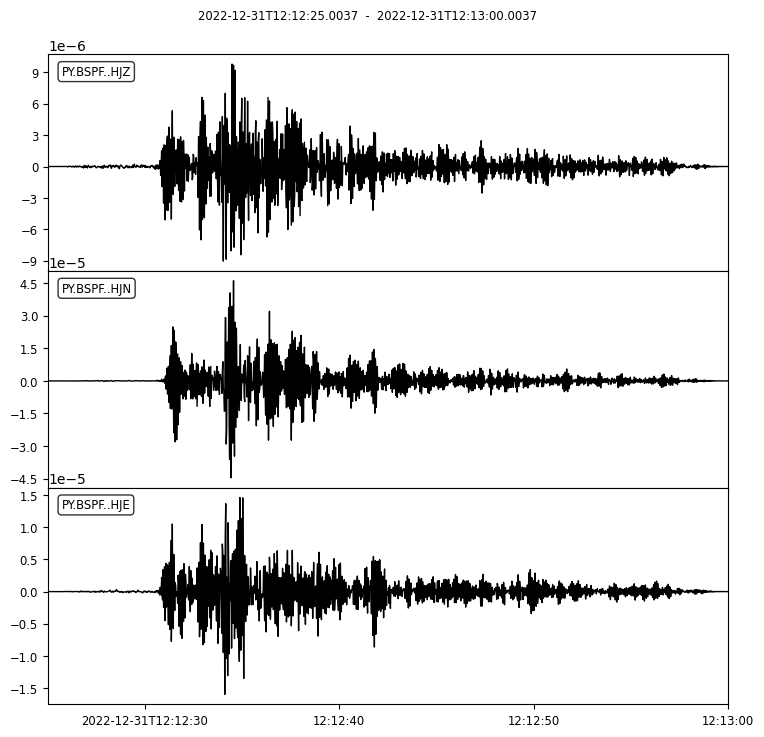

In [491]:
py_bspf = py_bspf0.copy()

## merge traces that might be split due to data gaps or overlaps
py_bspf.merge(fill_value="interpolate")

## renove sensitivity
py_bspf.remove_sensitivity(py_bspf_inv)

## resample to 40 Hz
py_bspf.resample(40)

## cut to event
py_bspf.trim(config['tbeg'], config['tend'])

## remove mean
py_bspf.detrend("demean")

## apply taper
py_bspf.taper(0.1)

## bandpass filter
py_bspf.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

## adjust channel names
for tr in py_bspf:
    if tr.stats.channel[-1] == "1":
        tr.stats.channel = str(tr.stats.channel).replace("1","E")
    if tr.stats.channel[-1] == "2":
        tr.stats.channel = str(tr.stats.channel).replace("2","N")        
    if tr.stats.channel[-1] == "3":
        tr.stats.channel = str(tr.stats.channel).replace("3","Z")

## show all traces in data stream
print(py_bspf)

py_bspf.plot(equal_scale=False);

## Compare with Seismometer

In [492]:
ii_pfo0, ii_pfo_inv = __request_data(config['seed_seismometer'], config['tbeg'], config['tend'])

3 Trace(s) in Stream:
II.PFO.10.BHN | 2022-12-31T12:12:24.994538Z - 2022-12-31T12:12:59.994538Z | 40.0 Hz, 1401 samples
II.PFO.10.BHE | 2022-12-31T12:12:24.994538Z - 2022-12-31T12:12:59.994538Z | 40.0 Hz, 1401 samples
II.PFO.10.BHZ | 2022-12-31T12:12:24.994538Z - 2022-12-31T12:12:59.994538Z | 40.0 Hz, 1401 samples


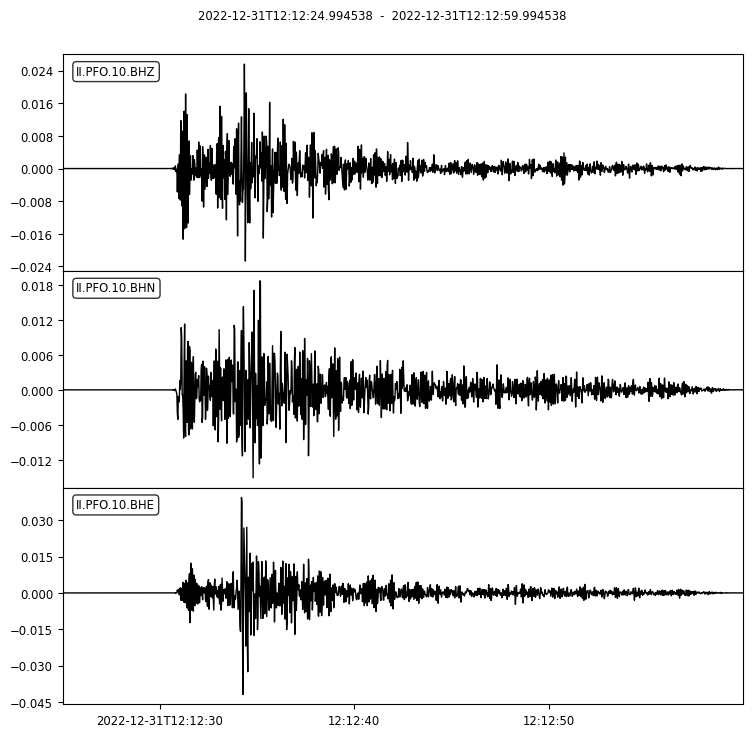

In [493]:
ii_pfo = ii_pfo0.copy()

pre_filt = [0.005, 0.01, 19, 20]

## cut properly
ii_pfo.trim(config['tbeg'], config['tend'])

## demean
ii_pfo.detrend("demean")

## remove response
ii_pfo.remove_response(inventory=ii_pfo_inv, output="ACC",plot=False)

## taper 
ii_pfo.taper(0.1)

## bandpass
ii_pfo.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

## adjust channel names
for tr in ii_pfo:
    if tr.stats.channel[-1] == "1":
        tr.stats.channel = str(tr.stats.channel).replace("1","N")
    if tr.stats.channel[-1] == "2":
        tr.stats.channel = str(tr.stats.channel).replace("2","E")
        
print(ii_pfo)
ii_pfo.plot(equal_scale=False);

### Join Data

In [494]:
st_new = py_bspf.copy()
st_new += ii_pfo

### Plotting

In [495]:
def __makeplot(config, st0):

    st = st0.copy()
    
    fig, ax = plt.subplots(len(st),1, figsize=(15,10), sharex=True)

    font = 14

    time_scaling, time_unit = 1, "sec"
    rot_scaling = 1e9
    trans_scaling = 1e6
    
    for i, tr in enumerate(st):

        if i in [0,1,2]:
            ax[i].set_ylabel(r"$\omega$ (nrad/s)", fontsize=font)
            ax[i].plot(tr.times()/time_scaling, tr.data*rot_scaling, 'k', label=tr.stats.station+"."+tr.stats.channel)

        elif i in [3,4,5]:
            ax[i].set_ylabel(r"u ($\mu$m/s)", fontsize=font)
            ax[i].plot(tr.times()/time_scaling, tr.data*trans_scaling, 'k', label=tr.stats.station+"."+tr.stats.channel)
        
        elif i in [6,7,8]:
            ax[i].set_ylabel(r"$\omega$ (nrad/s)", fontsize=font)
            ax[i].plot(tr.times()/time_scaling, tr.data*rot_scaling, 'k', label=tr.stats.station+"."+tr.stats.channel)
            
        ax[i].legend(loc=1)
        
    ax[len(st)-1].set_xlabel(f"Time ({time_unit}) from {st[0].stats.starttime.date} {str(st[0].stats.starttime.time).split('.')[0]} UTC", fontsize=font)
    ax[0].set_title(config['title']+f" | {config['fmin']} - {config['fmax']} Hz", fontsize=font, pad=10)
    
    plt.show();
    return fig

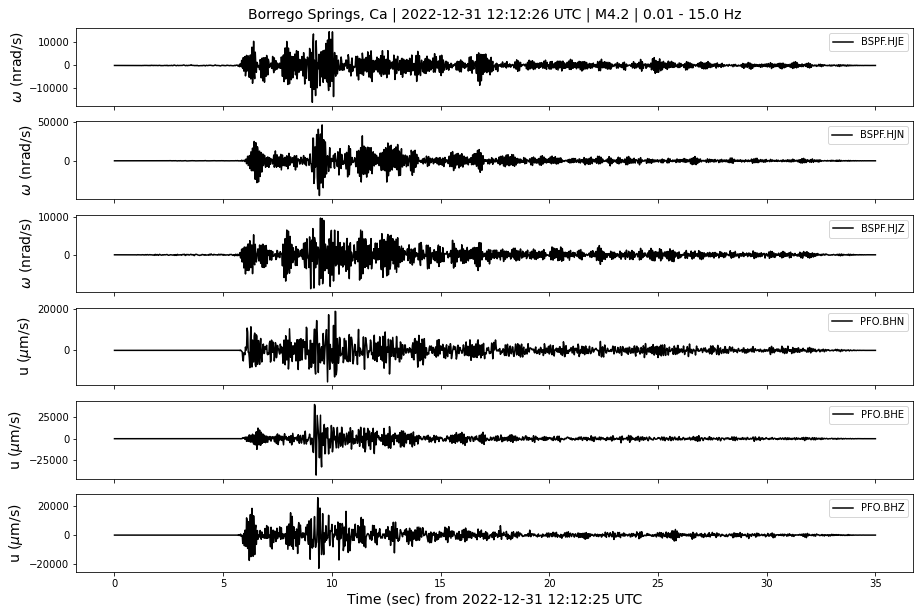

In [496]:
fig = __makeplot(config, st_new)

In [497]:
# __savefig(fig, outpath="/home/andbro/Downloads/tmp/BSPF/", outname="BSPF_event_1", mode="png", dpi=300)

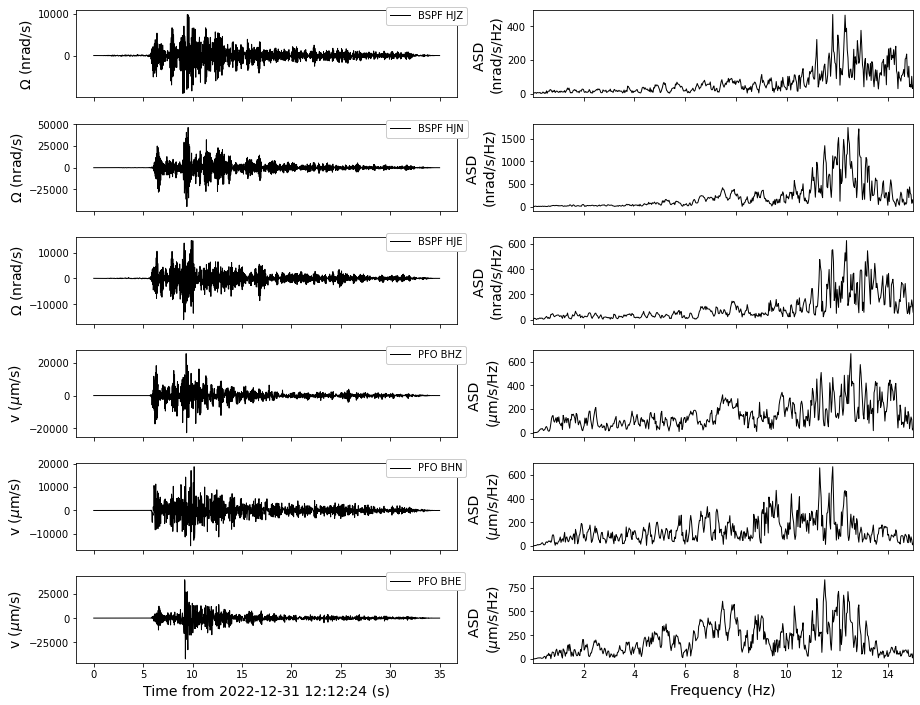

In [498]:
def __makeplotStreamSpectra2(st, config, fscale=None):

    from scipy import fftpack
    from andbro__fft import __fft
    import matplotlib.pyplot as plt

    NN = len(st)
    rot_scaling, rot_unit = 1e9, r"nrad/s"
    trans_scaling, trans_unit = 1e6, r"$\mu$m/s"
        
    fig, axes = plt.subplots(NN,2,figsize=(15,int(NN*2)), sharex='col')

    font = 14
    
    plt.subplots_adjust(hspace=0.3)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)
    
    for i, tr in enumerate(st):

#         comp_fft = abs(fftpack.fft(tr.data))
#         ff       = fftpack.fftfreq(comp_fft.size, d=1/tr.stats.sampling_rate)
#         comp_fft = fftpack.fftshift(comp_fft)
#         ff, spec = ff[1:len(ff)//2], abs(fftpack.fft(tr.data)[1:len(ff)//2])

        if tr.stats.channel[-2] == "J":
            scaling = rot_scaling
        elif tr.stats.channel[-2] == "H":
            scaling = trans_scaling

        spec, ff, ph = __fft(tr.data*scaling, tr.stats.delta, window=None, normalize=None)
    
    
        ## _________________________________________________________________
        if tr.stats.channel[-2] == "J":
            axes[i,0].plot(
                        tr.times(),
                        tr.data*rot_scaling,
                        color='black',
                        label='{} {}'.format(tr.stats.station, tr.stats.channel),
                        lw=1.0,
                        )

        elif tr.stats.channel[-2] == "H":
            axes[i,0].plot(
                        tr.times(),
                        tr.data*trans_scaling,
                        color='black',
                        label='{} {}'.format(tr.stats.station, tr.stats.channel),
                        lw=1.0,
                        )
        ## _________________________________________________________________
        if fscale == "loglog":
            axes[i,1].loglog(ff, spec, color='black', lw=1.0)
        elif fscale == "loglin":
            axes[i,1].semilogx(ff, spec, color='black', lw=1.0)
        elif fscale == "linlog":
            axes[i,1].semilogy(ff, spec, color='black', lw=1.0)
        else:
            axes[i,1].plot(ff, spec, color='black', lw=1.0)         
        
        
        if tr.stats.channel[1] == "J":
            sym, unit = r"$\Omega$", rot_unit
        elif tr.stats.channel[1] == "H":
            sym, unit = "v", trans_unit
        else:
            unit = "Amplitude", "a.u."
            
        axes[i,0].set_ylabel(f'{sym} ({unit})',fontsize=font)    
        axes[i,1].set_ylabel(f'ASD \n({unit}/Hz)',fontsize=font)        
        axes[i,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.10), framealpha=1.0)
        
#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    if "fmin" in config.keys() and "fmax" in config.keys():
        axes[i,1].set_xlim(config['fmin'],config['fmax'])

    axes[NN-1,0].set_xlabel(f"Time from {tr.stats.starttime.date} {str(tr.stats.starttime.time)[:8]} (s)",fontsize=font)     
    axes[NN-1,1].set_xlabel(f"Frequency (Hz)",fontsize=font)     

    return fig

fig = __makeplotStreamSpectra2(st_new, config, fscale="linlin");

In [499]:
# __savefig(fig, outpath="/home/andbro/Downloads/tmp/BSPF/", outname="BSPF_ASD_event_1", mode="png", dpi=300)

In [500]:
def __makeplotStreamSpectra3(st0, config):

    from scipy import fftpack
    from andbro__fft import __fft
    from matplotlib.gridspec import GridSpec
    import matplotlib.pyplot as plt

    st = st0.copy()
    
    NN = 5
    rot_scaling, rot_unit = 1e9, r"nrad/s"
    trans_scaling, trans_unit = 1e6, r"$\mu$m/s"
    
    rot_scaling, rot_unit = 1, r"nrad/s"
    trans_scaling, trans_unit = 1, r"$\mu$m/s"

    colors = ['crimson', 'red', 'magenta', 'darkblue', 'navy', 'indigo']

#     fig, axes = plt.subplots(NN, 2 ,figsize=(15, int(NN*2)), sharex='col', layout="constrained")
    fig = plt.figure(figsize=(15,12))
    
    gs = GridSpec(NN, 2, figure=fig)
    
    ax1 = fig.add_subplot(gs[0, :-1])
    ax2 = fig.add_subplot(gs[1, :-1])
    ax3 = fig.add_subplot(gs[2, :-1])

    ax4 = fig.add_subplot(gs[0, 1:])
    ax5 = fig.add_subplot(gs[1, 1:])
    ax6 = fig.add_subplot(gs[2, 1:])

    ax7 = fig.add_subplot(gs[3:, :])
    
    
    font = 14
    
    plt.subplots_adjust(hspace=0.1)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)
    
    ffs, specs, names = [], [], []
    for i, tr in enumerate(st):

        tr = tr.normalize()
        
        if tr.stats.channel[-2] == "J":
            scaling = rot_scaling
        elif tr.stats.channel[-2] == "H":
            scaling = trans_scaling

        spec, ff, ph = __fft(tr.data*scaling, tr.stats.delta, window=None, normalize=True)
        
        ffs.append(ff)
        specs.append(spec)
        names.append(f"{tr.stats.station}.{tr.stats.channel}")
    
    hz = st.select(channel="*HZ")[0]
    hn = st.select(channel="*HN")[0]
    he = st.select(channel="*HE")[0]

    jz = st.select(channel="*JZ")[0]
    jn = st.select(channel="*JN")[0]
    je = st.select(channel="*JE")[0]

    ax1.plot(hz.times(), hz.data*trans_scaling, 'k', label=f"{hz.stats.station}.{hz.stats.channel}")
    ax2.plot(hn.times(), hn.data*trans_scaling, 'k', label=f"{hn.stats.station}.{hn.stats.channel}")
    ax3.plot(he.times(), he.data*trans_scaling, 'k', label=f"{he.stats.station}.{he.stats.channel}")

    ax4.plot(jz.times(), jz.data*rot_scaling, 'k', label=f"{jz.stats.station}.{jz.stats.channel}")
    ax5.plot(jn.times(), jn.data*rot_scaling, 'k', label=f"{jn.stats.station}.{jn.stats.channel}")
    ax6.plot(je.times(), je.data*rot_scaling, 'k', label=f"{je.stats.station}.{je.stats.channel}")

    
    for ii, (ff, spec, name) in enumerate(zip(ffs, specs, names)):
        ax7.plot(ff, spec, label=name, alpha=0.6, color=colors[ii])
    
    
    for ax in [ax1, ax2, ax3, ax4 ,ax5, ax6]:
        ax.legend(loc=1, fontsize=font-2)
        ax.set_ylim(-1,1)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        if ax not in [ax3, ax6]:
            ax.set(xticklabels=[]) 
            ax.tick_params(bottom=False)  
        
        
    if "fmin" in config.keys() and "fmax" in config.keys():
        ax7.set_xlim(config['fmin'], config['fmax'])    
    
    ax7.legend(loc=2, fontsize=font-2)

    ax3.set_xlabel("Time (s)", fontsize=font)
    ax6.set_xlabel("Time (s)", fontsize=font)

    ax7.set_xlabel("Frequency (Hz)", fontsize=font)
    ax7.set_ylabel("Spec. Amplitude ()", fontsize=font)
    
    bbox = list(ax7.get_position().bounds)
    bbox[3] = .9*bbox[3] # Reduce the height of the axis a bit.
    ax7.set_position(bbox)
    
#     axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#     axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    return fig

Spectrum normalized 

Spectrum normalized 

Spectrum normalized 

Spectrum normalized 

Spectrum normalized 

Spectrum normalized 



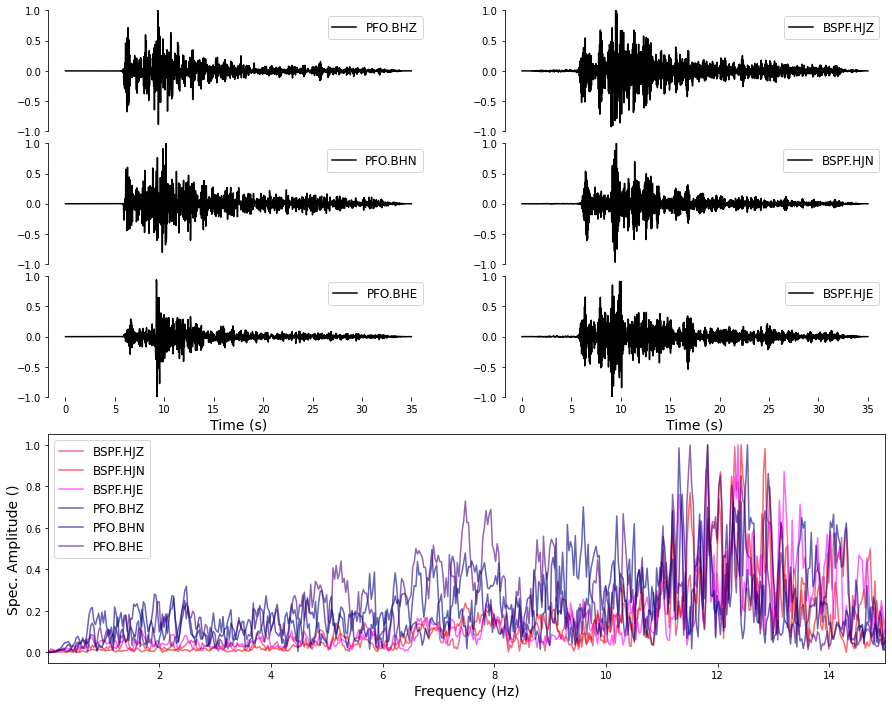

In [501]:
fig = __makeplotStreamSpectra3(st_new, config);

### ZRT

In [502]:
baz = __get_theo_baz(config)

In [503]:
from obspy.signal.rotate import rotate_ne_rt

## rotate acc NE to RT   
acc = st_new.copy().select(station="PFO")

acc_N = acc.select(channel='*N')[0]
acc_E = acc.select(channel='*E')[0]

acc_N.data, acc_E.data = rotate_ne_rt(acc_N.data, acc_E.data, baz)

# acc_N.stats.channel = "BHR"
# acc_E.stats.channel = "BHT"

## rotate rot NE to RT   
rot = st_new.copy().select(station="BSPF")

rot_N = rot.select(channel='*N')[0]
rot_E = rot.select(channel='*E')[0]

rot_N.data, rot_E.data = rotate_ne_rt(rot_N.data, rot_E.data, baz)

# rot_N.stats.channel = "HJR"
# rot_E.stats.channel = "HJT"

st_zrt = obs.Stream()

st_zrt += st_new.copy().select(channel="*HZ")[0]
st_zrt += st_new.copy().select(channel="*JZ")[0]
st_zrt += acc_N
st_zrt += acc_E
st_zrt += rot_N
st_zrt += rot_E

# st_zrt.plot();

Spectrum normalized 

Spectrum normalized 

Spectrum normalized 

Spectrum normalized 

Spectrum normalized 

Spectrum normalized 



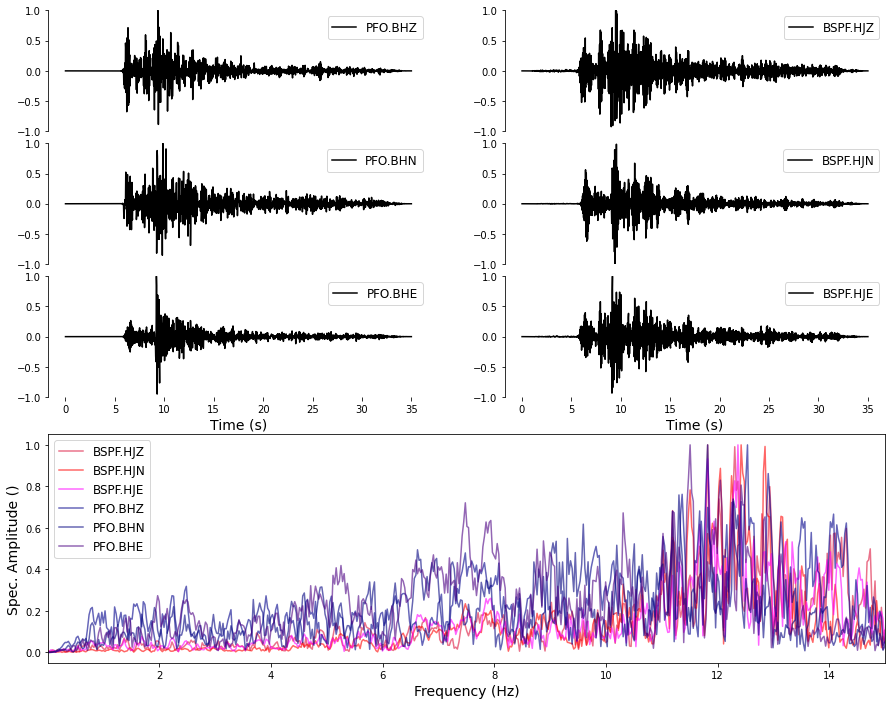

In [504]:
fig = __makeplotStreamSpectra3(st_zrt, config);

## Load ADR 

In [505]:
from functions.compute_adr_pfo import __compute_adr_pfo

In [506]:
adr = __compute_adr_pfo(config['tbeg'], config['tend'])

No data available for request.
Detailed response of server:


 -> geting waveforms failed ofr BPH05...
 -> continue computing ADR for 12 stations ...
3 Trace(s) in Stream:
PY.BPH01..BHZ | 2022-12-31T12:12:15.021900Z - 2022-12-31T12:13:09.996900Z | 40.0 Hz, 2200 samples
PY.BPH01..BHN | 2022-12-31T12:12:15.021900Z - 2022-12-31T12:13:09.996900Z | 40.0 Hz, 2200 samples
PY.BPH01..BHE | 2022-12-31T12:12:15.021900Z - 2022-12-31T12:13:09.996900Z | 40.0 Hz, 2200 samples

 Runtime: 0.6 minutes


In [507]:
## taper 
adr.taper(0.1)

## bandpass
adr.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

3 Trace(s) in Stream:
PY.RPFO..BJZ | 2022-12-31T12:12:25.021900Z - 2022-12-31T12:12:59.996900Z | 40.0 Hz, 1400 samples
PY.RPFO..BJN | 2022-12-31T12:12:25.021900Z - 2022-12-31T12:12:59.996900Z | 40.0 Hz, 1400 samples
PY.RPFO..BJE | 2022-12-31T12:12:25.021900Z - 2022-12-31T12:12:59.996900Z | 40.0 Hz, 1400 samples

3 Trace(s) in Stream:
PY.RPFO..BJZ | 2022-12-31T12:12:25.021900Z - 2022-12-31T12:12:59.996900Z | 40.0 Hz, 1400 samples
PY.RPFO..BJN | 2022-12-31T12:12:25.021900Z - 2022-12-31T12:12:59.996900Z | 40.0 Hz, 1400 samples
PY.RPFO..BJE | 2022-12-31T12:12:25.021900Z - 2022-12-31T12:12:59.996900Z | 40.0 Hz, 1400 samples

In [508]:
def __makeplot2(config, st0):

    st = st0.copy()
    
    fig, ax = plt.subplots(len(st),1, figsize=(15,10), sharex=True)

    font = 14

    time_scaling, time_unit = 1, "sec"
    rot_scaling = 1
    trans_scaling = 1
    
    for i, tr in enumerate(st):

        if i in [0,1,2]:
#             ax[i].set_ylabel(r"$\omega$ (nrad/s)", fontsize=font)
            ax[i].plot(tr.times()/time_scaling, tr.data*rot_scaling, 'k', label=tr.stats.station+"."+tr.stats.channel)

        elif i in [3,4,5]:
#             ax[i].set_ylabel(r"u ($\mu$m/s)", fontsize=font)
            ax[i].plot(tr.times()/time_scaling, tr.data*trans_scaling, 'k', label=tr.stats.station+"."+tr.stats.channel)
        
        elif i in [6,7,8]:
#             ax[i].set_ylabel(r"$\omega$ (nrad/s)", fontsize=font)
            ax[i].plot(tr.times()/time_scaling, tr.data*rot_scaling, 'k', label=tr.stats.station+"."+tr.stats.channel)
         
        ax[i].set_ylim(-1,1)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        if i != int(len(st)-1):
            ax[i].spines['bottom'].set_visible(False)
#             ax[i].set(xticklabels=[]) 
            ax[i].tick_params(bottom=False)
        
        ax[i].legend(loc=1)
        
    ax[len(st)-1].set_xlabel(f"Time ({time_unit}) from {st[0].stats.starttime.date} {str(st[0].stats.starttime.time).split('.')[0]} UTC", fontsize=font)
    ax[0].set_title(config['title']+f" | {config['fmin']} - {config['fmax']} Hz", fontsize=font, pad=10)
    
    plt.show();
    return fig

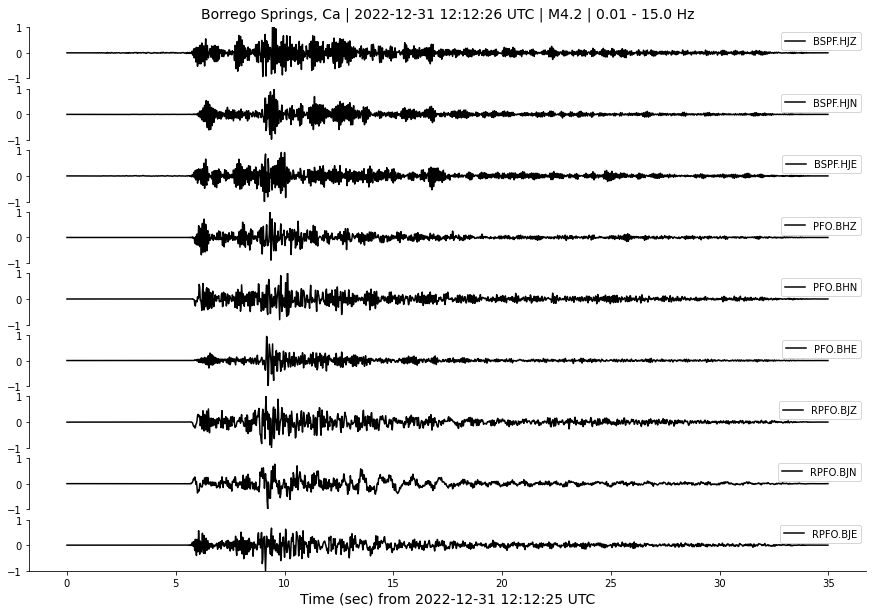

In [509]:
st_all = st_new.copy()
st_all += adr.copy()

st_all = st_all.trim(adr[0].stats.starttime, adr[0].stats.endtime)

st_all = st_all.normalize()

fig = __makeplot2(config, st_all)

In [510]:
st_adr = obs.Stream()
st_adr += py_bspf.copy()
st_adr += adr.copy()

st_adr = st_adr.trim(adr[0].stats.starttime, adr[0].stats.endtime)

In [511]:
def __makeplotStreamSpectra4(st0, config):

    from scipy import fftpack
    from andbro__fft import __fft
    from matplotlib.gridspec import GridSpec
    from andbro__compute_coherence_stream import __coherence_stream
    from numpy import array
    
    import matplotlib.pyplot as plt

    st = st0.copy()
    
    NN = 5
    rot_scaling, rot_unit = 1e9, r"nrad/s"
    trans_scaling, trans_unit = 1e6, r"$\mu$m/s"
    
    rot_scaling, rot_unit = 1, r"nrad/s"
    trans_scaling, trans_unit = 1, r"$\mu$m/s"

    colors = ['crimson', 'red', 'magenta', 'darkblue', 'navy', 'indigo']

    fig = plt.figure(figsize=(15,12))
    
    gs = GridSpec(NN, 2, figure=fig)
    
    ax1 = fig.add_subplot(gs[0, :-1])
    ax2 = fig.add_subplot(gs[1, :-1])
    ax3 = fig.add_subplot(gs[2, :-1])

    ax4 = fig.add_subplot(gs[0, 1:])
    ax5 = fig.add_subplot(gs[1, 1:])
    ax6 = fig.add_subplot(gs[2, 1:])

    ax7 = fig.add_subplot(gs[3:, :])
    
    
    font = 14
    
    plt.subplots_adjust(hspace=0.1)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)
    
    ff, spec = __coherence_stream(st, st.select(channel="HJZ"), nseg=256, nover=50)
    
    names, ffs, specs = [], [], []
    for i, tr in enumerate(st):
        tr = tr.normalize()
        
        ffs.append(ff[i])
        specs.append(spec[i][0])
        names.append(f"{tr.stats.station}.{tr.stats.channel}")
        
        
    hz = st.select(channel="BJZ")[0]
    hn = st.select(channel="BJN")[0]
    he = st.select(channel="BJE")[0]

    jz = st.select(channel="HJZ")[0]
    jn = st.select(channel="HJN")[0]
    je = st.select(channel="HJE")[0]

    ax1.plot(hz.times(), hz.data*trans_scaling, 'k', label=f"{hz.stats.station}.{hz.stats.channel}")
    ax2.plot(hn.times(), hn.data*trans_scaling, 'k', label=f"{hn.stats.station}.{hn.stats.channel}")
    ax3.plot(he.times(), he.data*trans_scaling, 'k', label=f"{he.stats.station}.{he.stats.channel}")

    ax4.plot(jz.times(), jz.data*rot_scaling, 'k', label=f"{jz.stats.station}.{jz.stats.channel}")
    ax5.plot(jn.times(), jn.data*rot_scaling, 'k', label=f"{jn.stats.station}.{jn.stats.channel}")
    ax6.plot(je.times(), je.data*rot_scaling, 'k', label=f"{je.stats.station}.{je.stats.channel}")

    
    for ii, (ff, spec, name) in enumerate(zip(ffs, specs, names)):
        ax7.plot(ff, spec, label=name, alpha=0.6, color=colors[ii])
    
    
    for ax in [ax1, ax2, ax3, ax4 ,ax5, ax6]:
        ax.legend(loc=1, fontsize=font-2)
        ax.set_ylim(-1,1)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        if ax not in [ax3, ax6]:
            ax.set(xticklabels=[]) 
            ax.tick_params(bottom=False)  
        
        
    if "fmin" in config.keys() and "fmax" in config.keys():
        ax7.set_xlim(config['fmin'], config['fmax'])    
    
    ax7.legend(loc=2, fontsize=font-2)

    ax3.set_xlabel("Time (s)", fontsize=font)
    ax6.set_xlabel("Time (s)", fontsize=font)

    ax7.set_xlabel("Frequency (Hz)", fontsize=font)
    ax7.set_ylabel("Spec. Amplitude ()", fontsize=font)
    
    bbox = list(ax7.get_position().bounds)
    bbox[3] = .9*bbox[3] # Reduce the height of the axis a bit.
    ax7.set_position(bbox)
    
#     axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#     axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    return fig

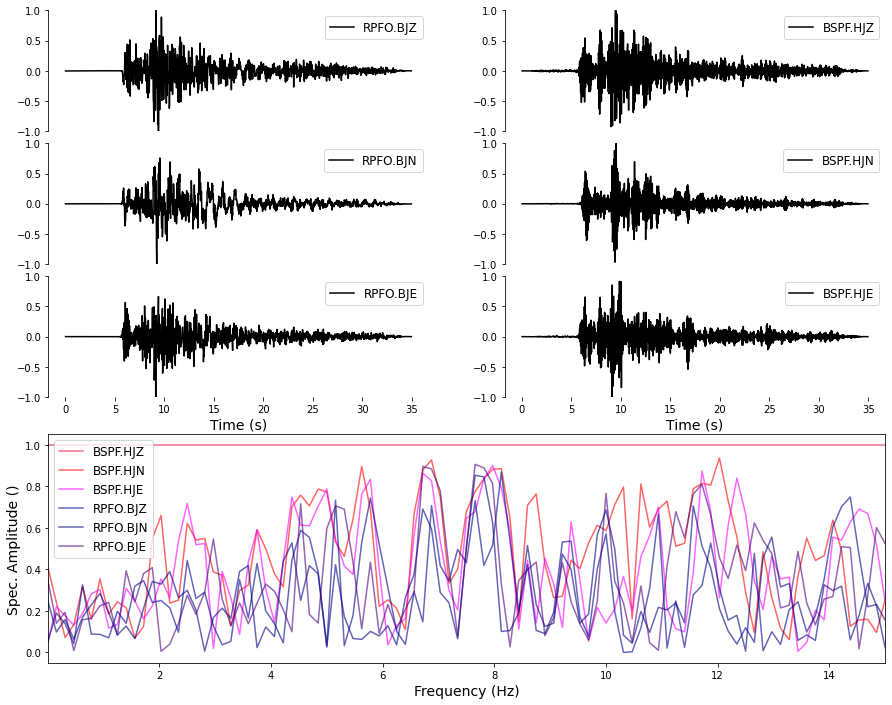

In [512]:
fig = __makeplotStreamSpectra4(st_adr, config);

In [513]:
def __makeplotStreamSpectra5(st0, config):

    from scipy import fftpack
    from andbro__fft import __fft
    from matplotlib.gridspec import GridSpec
    from andbro__crosscorrelation import __crosscorrelation
    from numpy import array
    
    import matplotlib.pyplot as plt

    st = st0.copy()
    
    NN = 5
    rot_scaling, rot_unit = 1e9, r"nrad/s"
    trans_scaling, trans_unit = 1e6, r"$\mu$m/s"
    
    rot_scaling, rot_unit = 1, r"nrad/s"
    trans_scaling, trans_unit = 1, r"$\mu$m/s"

    colors = ['crimson', 'red', 'magenta', 'darkblue', 'navy', 'indigo']

    fig = plt.figure(figsize=(15,12))
    
    gs = GridSpec(NN, 2, figure=fig)
    
    ax1 = fig.add_subplot(gs[0, :-1])
    ax2 = fig.add_subplot(gs[1, :-1])
    ax3 = fig.add_subplot(gs[2, :-1])

    ax4 = fig.add_subplot(gs[0, 1:])
    ax5 = fig.add_subplot(gs[1, 1:])
    ax6 = fig.add_subplot(gs[2, 1:])

    ax7 = fig.add_subplot(gs[3:, :])
    
    
    font = 14
    
    plt.subplots_adjust(hspace=0.1)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)
    
#     ff, spec = __coherence_stream(st, st.select(channel="HJZ"), nseg=256, nover=50)
    
    names, ffs, specs = [], [], []
    for comp in ["Z", "N", "E"]:
        
        tmp = st.select(channel=f"*{comp}")
        tmp.normalize()
        
        out = __crosscorrelation(tmp[0].data, tmp[1].data, deltaT=tmp[0].stats.delta, plot=False)
        
        ffs.append(out['xlags'])
        specs.append(out['ccorr'])
        names.append(f"{tmp[0].stats.channel}")
        
        
    hz = st.select(channel="BJZ")[0]
    hn = st.select(channel="BJN")[0]
    he = st.select(channel="BJE")[0]

    jz = st.select(channel="HJZ")[0]
    jn = st.select(channel="HJN")[0]
    je = st.select(channel="HJE")[0]

    ax1.plot(hz.times(), hz.data*trans_scaling, 'k', label=f"{hz.stats.station}.{hz.stats.channel}")
    ax2.plot(hn.times(), hn.data*trans_scaling, 'k', label=f"{hn.stats.station}.{hn.stats.channel}")
    ax3.plot(he.times(), he.data*trans_scaling, 'k', label=f"{he.stats.station}.{he.stats.channel}")

    ax4.plot(jz.times(), jz.data*rot_scaling, 'k', label=f"{jz.stats.station}.{jz.stats.channel}")
    ax5.plot(jn.times(), jn.data*rot_scaling, 'k', label=f"{jn.stats.station}.{jn.stats.channel}")
    ax6.plot(je.times(), je.data*rot_scaling, 'k', label=f"{je.stats.station}.{je.stats.channel}")

    
    for ii, (ff, spec, name) in enumerate(zip(ffs, specs, names)):
        ax7.plot(ff, spec, label=name, alpha=0.6, color=colors[ii])
    
    
    for ax in [ax1, ax2, ax3, ax4 ,ax5, ax6]:
        ax.legend(loc=1, fontsize=font-2)
        ax.set_ylim(-1,1)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        if ax not in [ax3, ax6]:
            ax.set(xticklabels=[]) 
            ax.tick_params(bottom=False)  
        
        
#     if "fmin" in config.keys() and "fmax" in config.keys():
#         ax7.set_xlim(config['fmin'], config['fmax'])    
    
    ax7.legend(loc=2, fontsize=font-2)

    ax3.set_xlabel("Time (s)", fontsize=font)
    ax6.set_xlabel("Time (s)", fontsize=font)

    ax7.set_xlabel("Frequency (Hz)", fontsize=font)
    ax7.set_ylabel("Spec. Amplitude ()", fontsize=font)
    
    bbox = list(ax7.get_position().bounds)
    bbox[3] = .9*bbox[3] # Reduce the height of the axis a bit.
    ax7.set_position(bbox)
    
#     axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#     axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    return fig

Maximum Correlation: 
 x: 167 
 y: 0.15
Maximum Correlation: 
 x: -42 
 y: 0.12
Maximum Correlation: 
 x: 74 
 y: 0.22


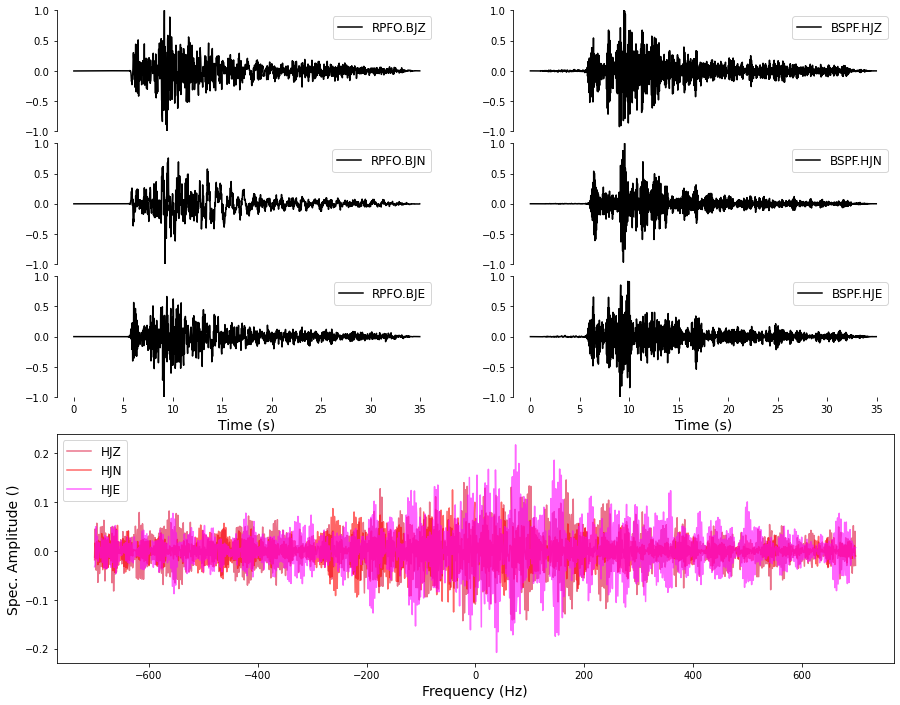

In [514]:
fig = __makeplotStreamSpectra5(st_adr, config);

## Backazimuth

In [515]:
config['station_longitude'] = config['BSPF_lon']
config['station_latitude']  = config['BSPF_lat']

config['win_length_sec'] = 1  ## window length for correlation
config['step'] = 1
config['overlap'] = 25

earthquake name :  16km N of Borrego Springs, CA

Epicentral distance [m]:        24334.6
Theoretical azimuth [deg]:      346.3
Theoretical backazimuth [deg]:  166.3


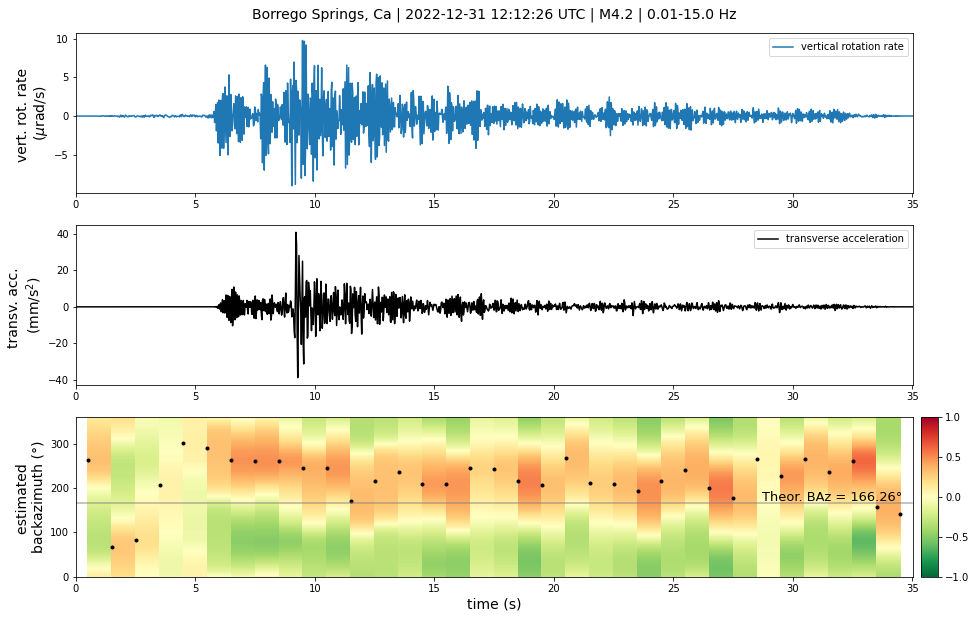

In [516]:
def __compute_backazimuth(st_acc, st_rot, config, event=None, plot=True):
    
    import numpy as np
    import matplotlib as mpl
    
    from obspy import read, read_events, UTCDateTime
    from obspy.clients.fdsn import Client
    from obspy.geodetics.base import gps2dist_azimuth
    from obspy.signal.cross_correlation import xcorr
    from obspy.signal.rotate import rotate_ne_rt

    ## _______________________________    
    ## check config
    keywords=['tbeg','tend','station_latitude', 'station_longitude',
              'step', 'win_length_sec', 'overlap', 'eventtime']

    for key in keywords: 
        if key not in config.keys():
            print(f" -> {key} is missing in config!\n")
            
            
    ## _______________________________    
    ## Defaults
    if 'win_length_sec' not in config.keys():
        config['win_length_sec'] = .5    ## window length for correlation
    if 'step' not in config.keys():
        config['step'] = 1
    if 'overlap' not in config.keys():
        config['overlap'] = 25
    
    
    ## time period
    config['tbeg'], config['tend'] = UTCDateTime(config['tbeg']), UTCDateTime(config['tend'])

    ## _______________________________    
    ## streams
    ACC = st_acc.trim(config['tbeg'], config['tend'])
    ROT = st_rot.trim(config['tbeg'], config['tend']).select(channel="*Z")
    
    ## _______________________________    
    ## get event if not provided
    if not event:
        events = Client("USGS").get_events(starttime=config['eventtime']-20, endtime=config['eventtime']+20)
        if len(events) > 1:
            print(f" -> {len(events)} events found!!!")
            print(events)
            
    event = events[0]
    
    ## event location from event info
    config['source_latitude'] = event.origins[0].latitude
    config['source_longitude'] = event.origins[0].longitude
    
    print(event.event_descriptions[0]['type'], ': ',event.event_descriptions[0]['text'] + "\n")
    

    ## _______________________________        
    ## theoretical backazimuth and distance
    
    config['baz'] = gps2dist_azimuth(
                                    config['source_latitude'], config['source_longitude'], 
                                    config['station_latitude'], config['station_longitude'],
                                    )

    print('Epicentral distance [m]:       ',np.round(config['baz'][0],1))
    print('Theoretical azimuth [deg]:     ', np.round(config['baz'][1],1))
    print('Theoretical backazimuth [deg]: ', np.round(config['baz'][2],1))

    ## _______________________________    
    ## backazimuth estimation
    
    config['sampling_rate'] = int(ROT.select(channel="*Z")[0].stats.sampling_rate)
    
    config['num_windows'] = len(ROT.select(channel="*Z")[0]) // (int(config['sampling_rate'] * config['win_length_sec']))

    
    backas = np.linspace(0, 360 - config['step'], int(360 / config['step']))
   
    corrbaz = []
    
    ind = None
    
    for i_deg in range(0, len(backas)):
        
        for i_win in range(0, config['num_windows']):
            
            ## infer indices
            idx1 = int(config['sampling_rate'] * config['win_length_sec'] * i_win)
            idx2 = int(config['sampling_rate'] * config['win_length_sec'] * (i_win + 1))
            
            ## add overlap
            if i_win > 0 and i_win < config['num_windows']:
                idx1 = int(idx1 - config['overlap']/100 * config['win_length_sec'] * config['sampling_rate'])
                idx2 = int(idx2 + config['overlap']/100 * config['win_length_sec'] * config['sampling_rate'])
                    
            ## rotate NE to RT   
            R, T = rotate_ne_rt(ACC.select(channel='*N')[0].data, 
                                ACC.select(channel='*E')[0].data,
                                backas[i_deg]
                               )
            
            ## compute correlation for backazimuth
            corrbaz0 = xcorr(ROT.select(channel="*Z")[0][idx1:idx2], 
                             T[idx1:idx2], 0,
                              )
            
            corrbaz.append(corrbaz0[1])

            
    corrbaz = np.asarray(corrbaz)
    corrbaz = corrbaz.reshape(len(backas), config['num_windows'])


    ## extract maxima
    maxcorr = np.array([backas[corrbaz[:, l1].argmax()] for l1 in range(0, config['num_windows'])])

    ## create mesh grid
    mesh = np.meshgrid(np.arange(config['win_length_sec']/2, config['win_length_sec'] * config['num_windows'], config['win_length_sec']), backas)

    

    ## _______________________________
    ## Plotting
    def __makeplot():
    
        ## get rotated acceleration
        R, T = rotate_ne_rt(ACC.select(component='N')[0].data, 
                            ACC.select(component='E')[0].data,
                            config['baz'][2]
                           )

        fig, ax = plt.subplots(3, 1, figsize=(15, 10))

        ## parameters
        font = 14
        acc_scaling, acc_unit = 1e3, "mm/s$^2$"
        rot_scaling, rot_unit = 1e6, "$\mu$rad/s"

        ## create time axis
        time = np.linspace(0, len(ACC[0].data)/ACC[0].stats.sampling_rate, len(ACC[0].data))

        ## plot vertical rotation rate
        ax[0].plot(time, ROT.select(channel="*Z")[0].data*rot_scaling, label='vertical rotation rate')

        ax[0].set_xlim(time[0], time[-1])
        ax[0].set_ylabel(f'vert. rot. rate \n({rot_unit})', fontsize=font)
        ax[0].legend()

        # add P- and S-wave arrivals
        ROT_max = max(ROT.select(channel="*Z")[0].data*rot_scaling)
        
        ## plot transverse acceleration
        ax[1].plot(time, T*acc_scaling, 'k',label='transverse acceleration')
        ax[1].set_xlim(time[0], time[-1])
        ax[1].set_ylabel(f'transv. acc. \n({acc_unit})', fontsize=font)
        ax[1].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
        ax[1].legend()
        

        ## backazimuth estimation plot
        im = ax[2].pcolormesh(mesh[0], mesh[1], corrbaz, cmap=plt.cm.RdYlGn_r, vmin=-1, vmax=1, shading="auto")
        ax[2].set_xlim(time[0], time[-1])
        ax[2].set_ylim(0, 360)
        ax[2].set_ylabel(u'estimated \nbackazimuth (°)', fontsize=font)
        ax[2].set_xlabel('time (s)', fontsize=font)

        ## plot maximal correclation values
        ax[2].plot(np.arange(config['win_length_sec']/2., config['win_length_sec'] * len(maxcorr), config['win_length_sec']), maxcorr, '.k')

        ## plot theoretical Backazimuth for comparison
        xx = np.arange(0, config['win_length_sec'] * len(maxcorr) + 1, config['win_length_sec'])
        tba = np.ones(len(xx)) * config['baz'][2]
        if config['baz'][2] < 330:
            x_text, y_text = time[int(0.82*len(time))], config['baz'][2]+5
        else:
            x_text, y_text = time[int(0.82*len(time))], config['baz'][2]-15

        ax[2].plot(xx, tba, c='.5', lw=1.5, alpha=0.6)
        ax[2].text(x_text, y_text, u'Theor. BAz = '+str(round(config['baz'][2],2))+'°', color='k', fontsize=font-1)

        if 'fmin' in config.keys() and 'fmax' in config.keys():
            ax[0].set_title(config['title'] + f" | {config['fmin']}-{config['fmax']} Hz", pad=15, fontsize=font)
        else:
            ax[0].set_title(config['title'], pad=15, fontsize=font)
 
            
        ## add colorbar
    #     norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    #     cb1 = mpl.colorbar.ColorbarBase(fig, cmap=plt.cm.RdYlGn_r, norm=norm, orientation='vertical')
        cax = ax[2].inset_axes([1.01, 0., 0.02, 1])
        cb1 = plt.colorbar(im, ax=ax[2], cax=cax)

        plt.show();
        return fig
    
    
    if plot:
        __makeplot();
        

    ## _______________________________
    ## prepare output        
    
    output = {}
    
    output['baz_mesh'] = mesh
    output['baz_corr'] = corrbaz
    output['baz_theo'] = config['baz']
    output['acc_transverse'] = T
    output['acc_radial'] = R
    output['rot_vertical'] = ROT.select(channel="*Z")
    output['event'] = event
    
    return output
        
out = __compute_backazimuth(ii_pfo, py_bspf, config, plot=True)